# Notebook reading VisiumHD Dataset of Mouse Lung using bin2cell
[Bin2Cell Tutorial](https://nbviewer.org/github/Teichlab/bin2cell/blob/main/notebooks/demo.ipynb)
- Dataset: https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-mouse-lung-fresh-frozen
- Created by: Christian Eger
- Created on: 19th of November 2024
- Environment: bin2cell-env

Bin2cell provides solutions for both reading VisiumHD datasets and aggregating its spots to cells.

## Setup

### Import modules

In [1]:
from pathlib import Path
from datetime import datetime
import logging

import bin2cell as b2c
import scanpy as sc
import tensorflow as tf
import numpy as np

from utilities import spatial_subset


for device in tf.config.list_physical_devices():
    print(device)

2024-11-20 15:16:30.923521: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 15:16:30.934780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732112190.946664  462917 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732112190.950392  462917 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 15:16:30.964135: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


### Setup paths

In [2]:
notebook_name = "0-b2c_load_raw_data.ipynb" 
notebook_path = Path.cwd() / notebook_name
notebook_execution_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
repo_path = Path.cwd().parent
data_folder_path = repo_path / ".data"

spatial_data_path = data_folder_path / "raw" / "VisiumHD_Mouse_Lung" / "binned_outputs" / "square_002um"
adata_path = data_folder_path / "processed" / "preprocessing" / "2024-11-05_19-08-36_VisiumHD_mouse_lung_square_002um.h5ad"


### Load and preprocess data

In [3]:
# Reading Data
adata = b2c.read_visium(spatial_data_path, source_image_path=data_folder_path / "raw" / "VisiumHD_Mouse_Lung" / "Visium_HD_Mouse_Lung_Fresh_Frozen_tissue_image.tif")
adata.var_names_make_unique()
adata.uns["log"] = {
    "dataset_name": "VisiumHD_mouse_lung"
}
adata.uns["log"][notebook_execution_time] = {
    "notebook_path": notebook_path,
    "processing_steps": str(),
}

# Filtering Data
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=1)
adata.uns["log"][notebook_execution_time]["processing_steps"] += \
"var_names_make_unique\n\
filter_genes, min_cells=3\n\
filter_cells, min_counts=1\n"
adata

anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 9117867 × 17743
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'log'
    obsm: 'spatial'

## Bin2Cell

In [4]:
mpp = 0.5
b2c.scaled_he_image(adata, mpp=mpp, save_path="stardist/he.tiff")

In [5]:
b2c.destripe(adata)

_construct.py (149): Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.


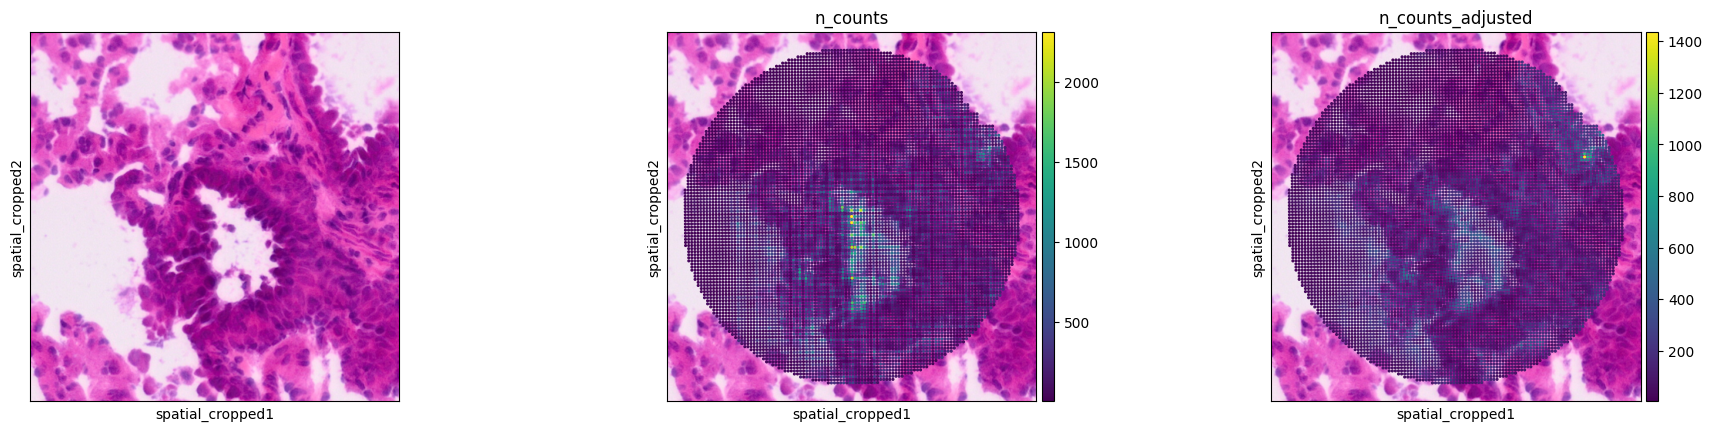

anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.


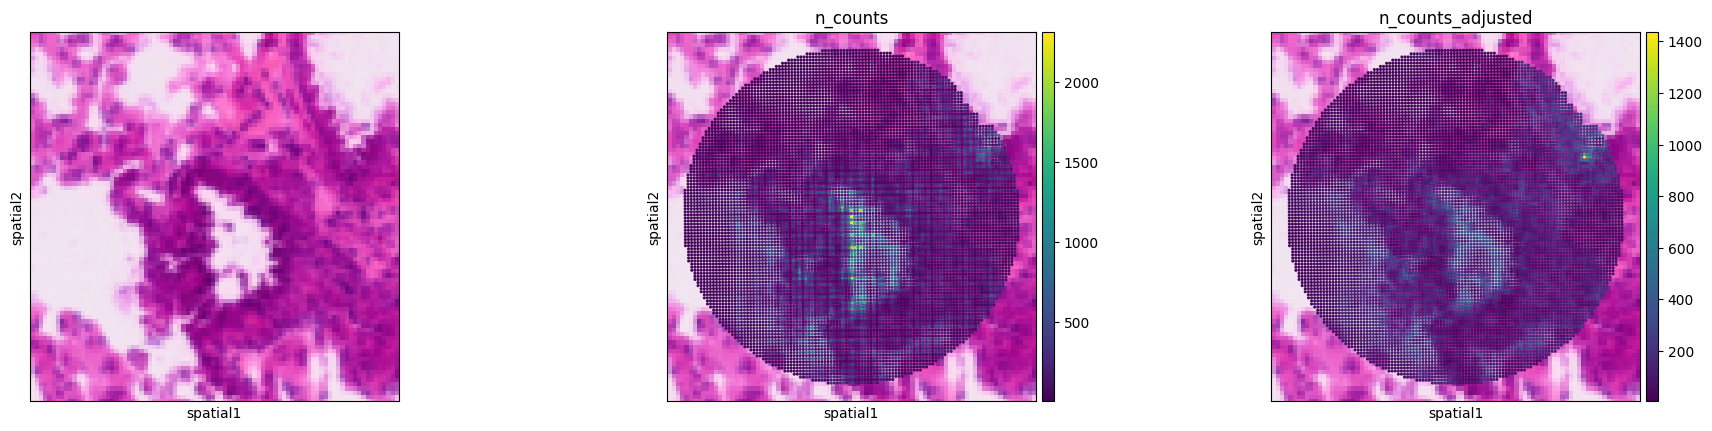

In [6]:
"""
Comparing the custom high resolution image with regular hires spaceranger image
The b2c tutorial suggests img_key="0.5_mpp_150_buffer" and basis="spatial_cropped_150_buffer", however this only worked after removing "_150_buffer"
"""
spatial_subset_params = (adata, ["circle"], [((11287, 35244), 400)], ["keep"])
sc.pl.spatial(spatial_subset(*spatial_subset_params), color=[None, "n_counts", "n_counts_adjusted"], img_key="0.5_mpp", basis="spatial_cropped")
sc.pl.spatial(spatial_subset(*spatial_subset_params), color=[None, "n_counts", "n_counts_adjusted"])

anndata.py (1145): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.


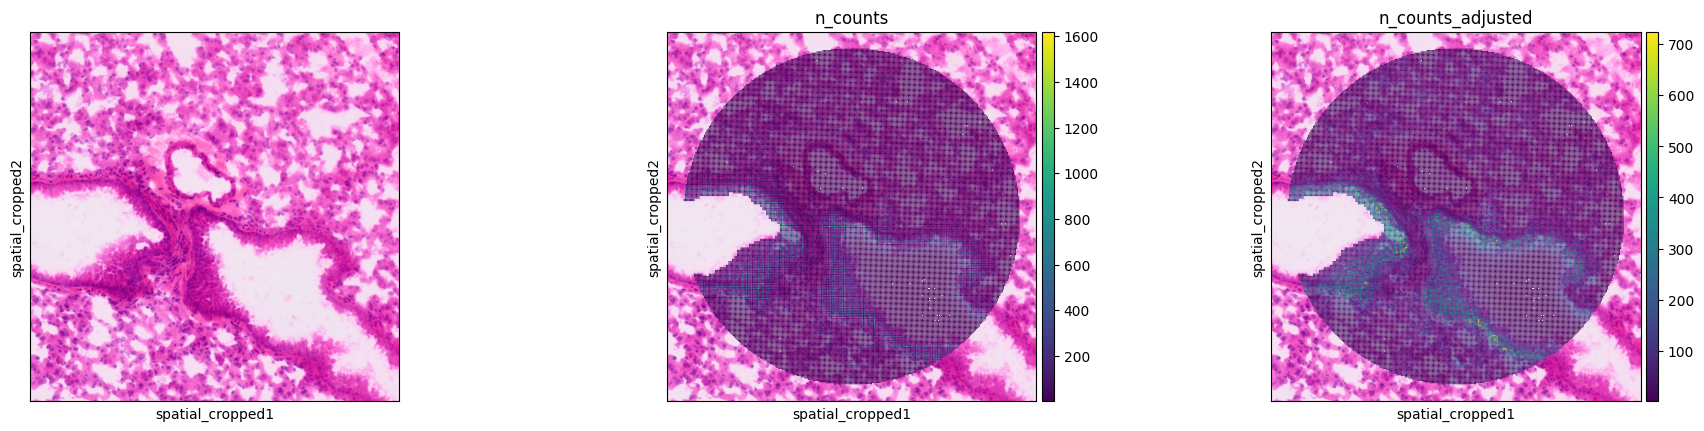

anndata.py (1145): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.


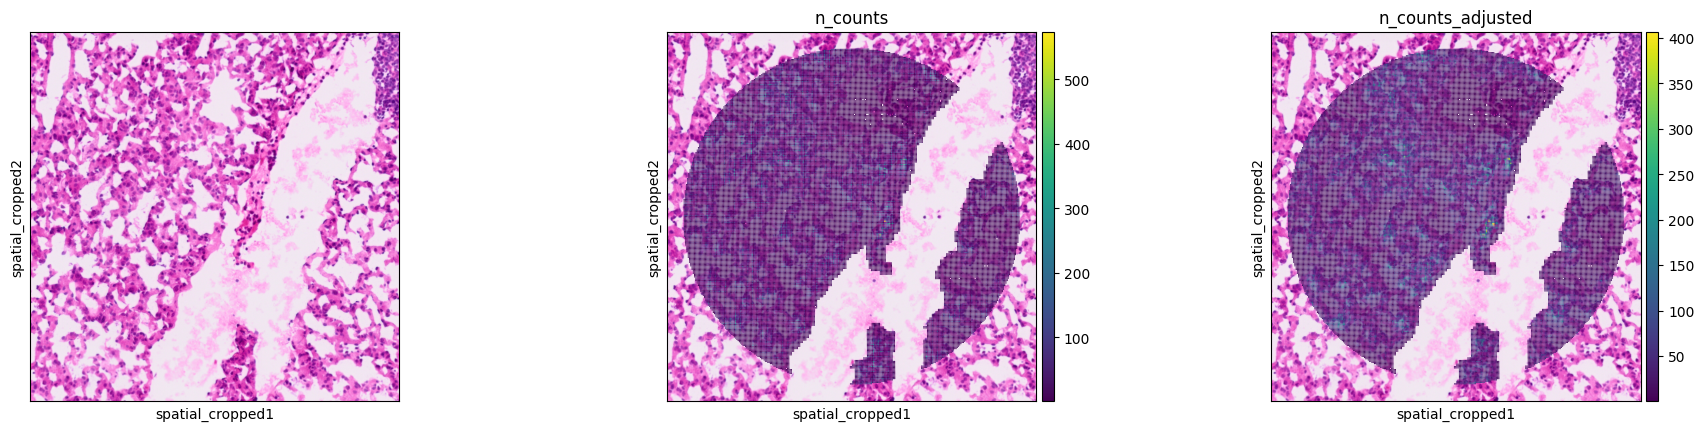

anndata.py (1145): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.


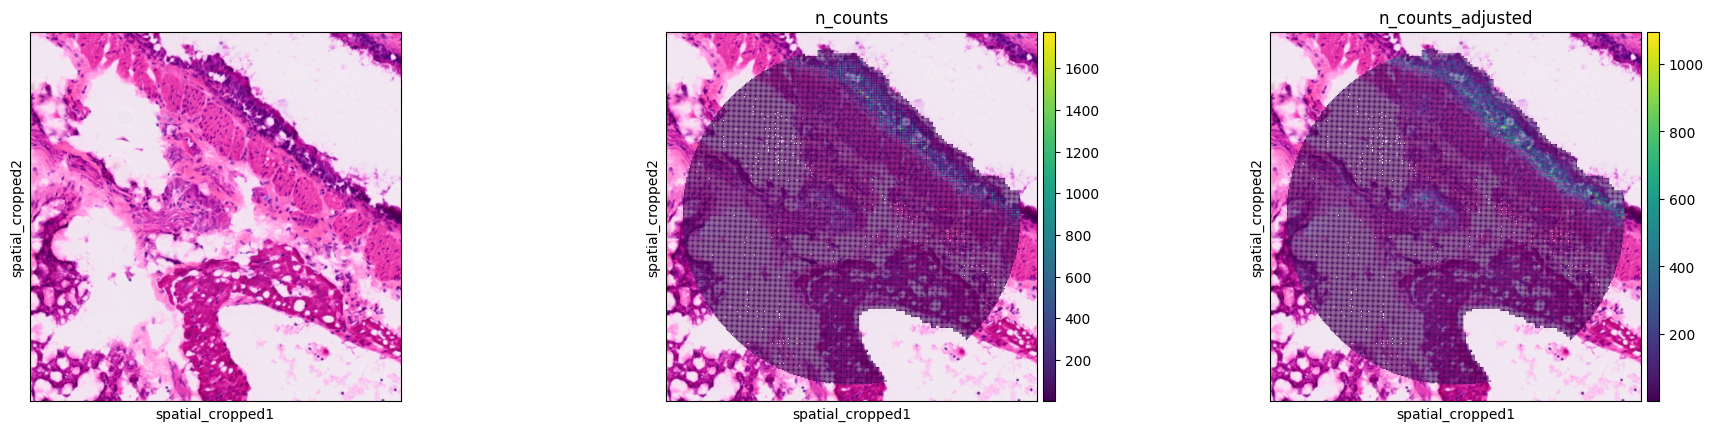

anndata.py (1145): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.


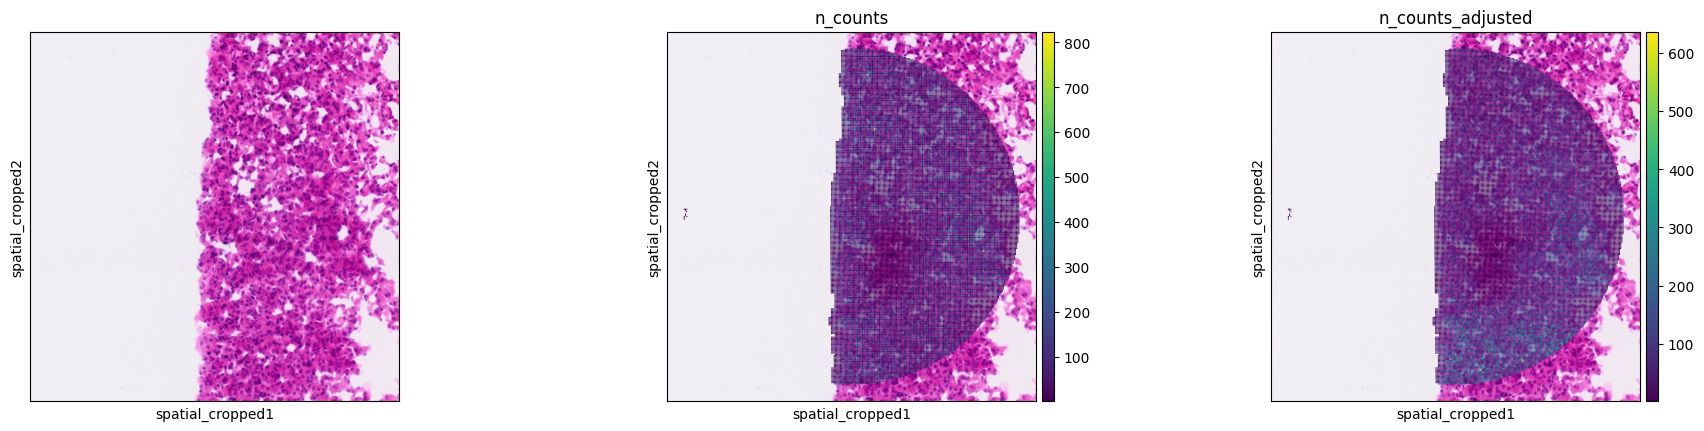

In [64]:
"""
Checking alignment of spots with microscope image on 4 random spots in the tissue
"""
np.random.seed(1776)
spots = [tuple(row) for row in adata[adata.obs["n_counts"] >= 50].obsm["spatial"][np.random.choice(adata[adata.obs["n_counts"] >= 50].obsm["spatial"].shape[0], 4, replace=False)]]
for spot in spots:
    sc.pl.spatial(spatial_subset(adata, ["circle"], [(spot, 1000)], ["keep"]), color=[None, "n_counts", "n_counts_adjusted"], img_key="0.5_mpp", basis="spatial_cropped")

In [8]:
b2c.stardist(
    image_path=data_folder_path / "raw" / "VisiumHD_Mouse_Lung" / "Visium_HD_Mouse_Lung_Fresh_Frozen_tissue_image.tif", 
    labels_npz_path=data_folder_path / "he.npz", 
    stardist_model="2D_versatile_he", 
    prob_thresh=0.01
)

Found model '2D_versatile_he' for 'StarDist2D'.


I0000 00:00:1732112484.428696  462917 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46569 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1732112484.430029  462917 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46569 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:02:00.0, compute capability: 8.9


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*
I0000 00:00:1732112485.518885  463492 service.cc:148] XLA service 0x7f75dc006280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732112485.518919  463492 service.cc:156]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1732112485.518923  463492 service.cc:156]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-11-20 15:21:25.550708: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732112485.623331  463492 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1732112486.283140  463492 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Found 481434 objects


In [10]:
import scipy

In [14]:
scipy.sparse.load_npz(str(data_folder_path / "he.npz"))

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 126666039 stored elements and shape (59538, 38362)>

In [17]:
b2c.insert_labels(adata, 
                  labels_npz_path=str(data_folder_path / "he.npz"), # gotta convert to a string, otherwise the function complains
                  basis="spatial", 
                  spatial_key="spatial_cropped",
                  mpp=mpp, 
                  labels_key="labels_he"
                 )
adata

AnnData object with n_obs × n_vars = 9117867 × 17743
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'log', 'bin2cell'
    obsm: 'spatial', 'spatial_cropped'

In [26]:
adata.obs = adata.obs.assign(labels_he_str=lambda x: x.labels_he.astype(str))
adata.obs

in_tissue  array_row  array_col  n_counts  \
s_002um_00658_01498-1          1        658       1498      47.0   
s_002um_02587_02503-1          1       2587       2503      54.0   
s_002um_01674_00710-1          1       1674        710      25.0   
s_002um_02498_02808-1          1       2498       2808       3.0   
s_002um_00952_00136-1          1        952        136      83.0   
...                          ...        ...        ...       ...   
s_002um_03248_02696-1          1       3248       2696       7.0   
s_002um_00212_00415-1          1        212        415      38.0   
s_002um_03062_00964-1          1       3062        964      17.0   
s_002um_00504_01845-1          1        504       1845      27.0   
s_002um_03170_00732-1          1       3170        732      62.0   

                       destripe_factor  n_counts_adjusted  labels_he  \
s_002um_00658_01498-1         0.708878         187.143798          0   
s_002um_02587_02503-1         0.077460          20.449457          0   
s_002um_01674_00710-1         0.391175         103.270254          0   
s_002um_02498_02808-1         0.077944          20.577116          0   
s_002um_00952_00136-1         0.408602         107.870847          0   
...                                ...                ...        ...   
s_002um_03248_02696-1         0.049358          13.030480          0   
s_002um_00212_00415-1         0.473624         125.036763          0   
s_002um_03062_00964-1         0.063845          16.855117          0   
s_002um_00504_01845-1         0.188007          49.633858          0   
s_002um_03170_00732-1         0.241113          63.653828          0   

                      labels_he_str  
s_002um_00658_01498-1             0  
s_002um_02587_02503-1             0  
s_002um_01674_00710-1             0  
s_002um_02498_02808-1             0  
s_002um_00952_00136-1             0  
...                             ...  
s_002um_03248_02696-1             0  
s_002um_00212_00415-1             0  
s_002um_03062_00964-1             0  
s_002um_00504_01845-1             0  
s_002um_03170_00732-1             0  

[9117867 rows x 8 columns]

anndata.py (1145): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.


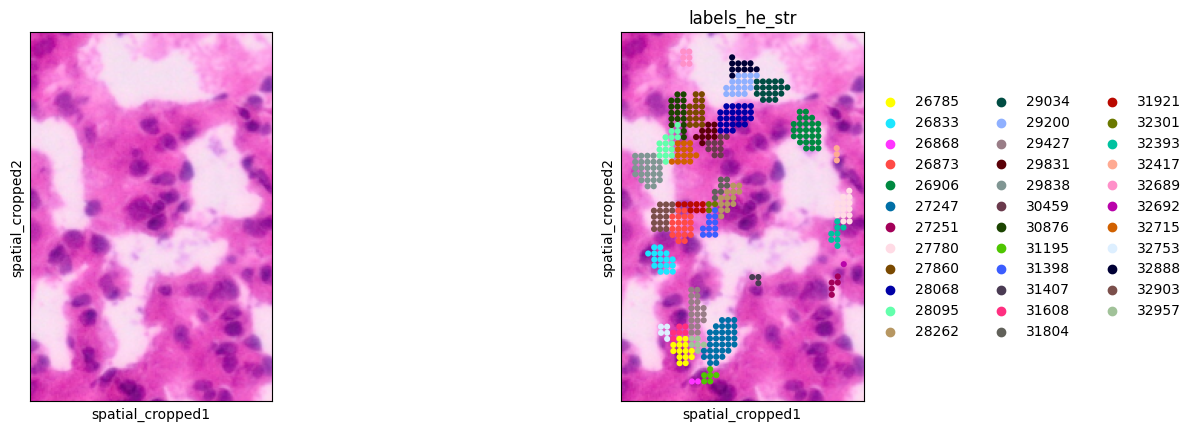

anndata.py (1145): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.


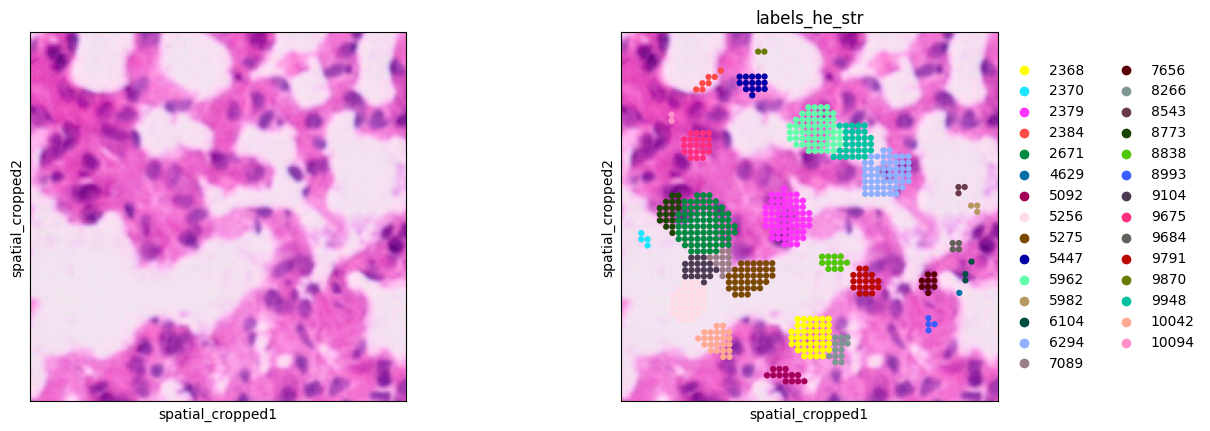

anndata.py (1145): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.


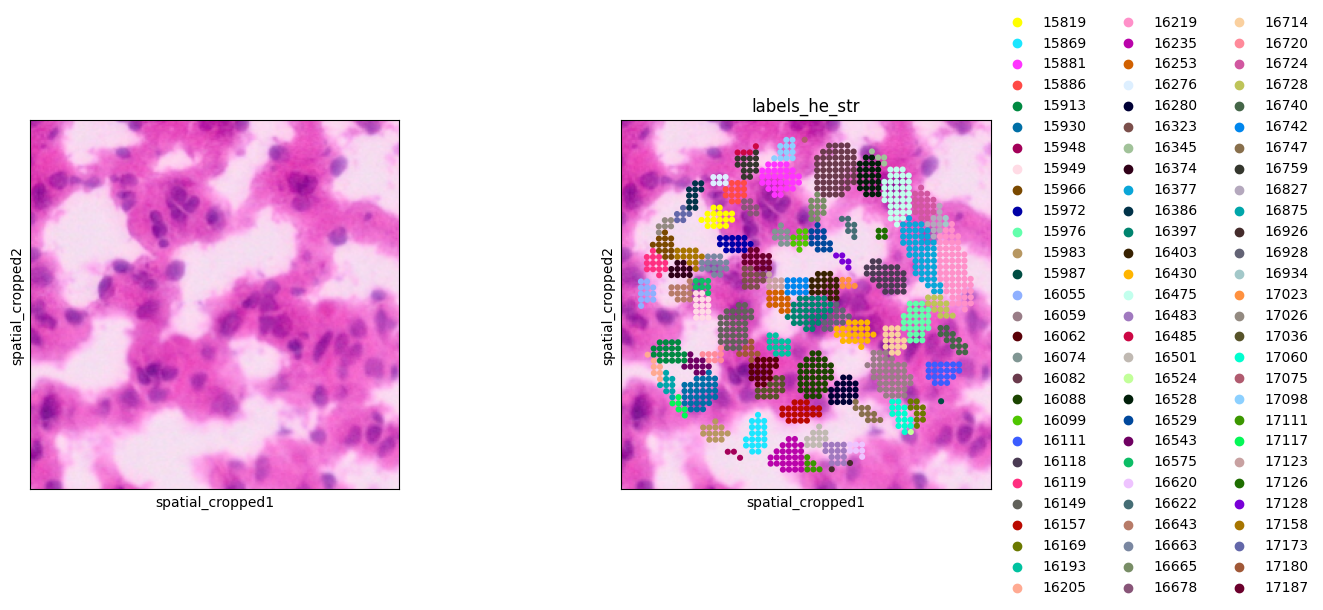

anndata.py (1145): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.


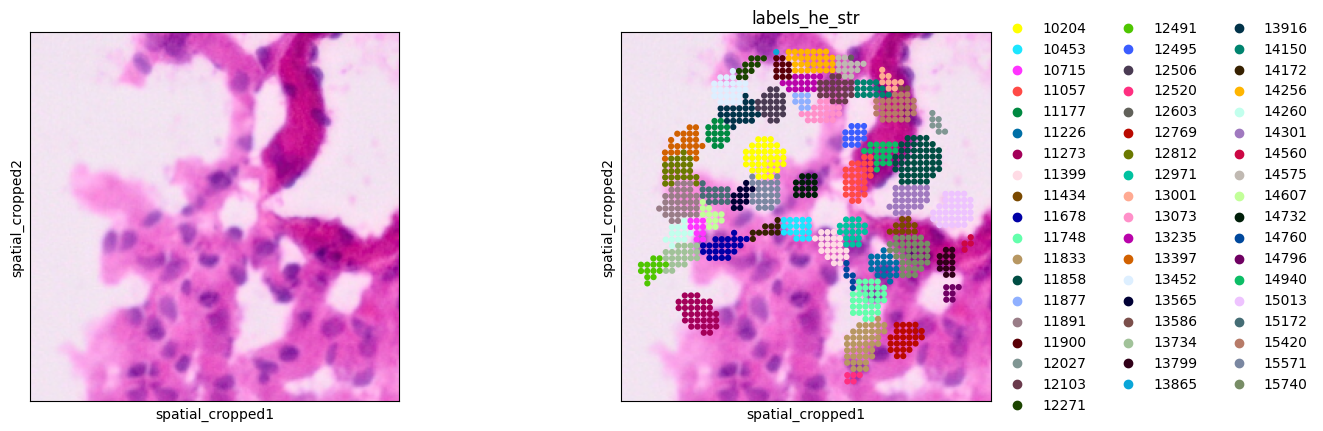

In [63]:
spots = [tuple(row) for row in adata[adata.obs["labels_he_str"] != "0"].obsm["spatial"][np.random.choice(adata[adata.obs["labels_he_str"] != "0"].shape[0], 4, replace=False)]]
for spot in spots:
    sc.pl.spatial(spatial_subset(adata[adata.obs["labels_he_str"] != "0"], ["circle"], [(spot, 200)], ["keep"]), color=[None, "labels_he_str"], img_key="0.5_mpp", basis="spatial_cropped")